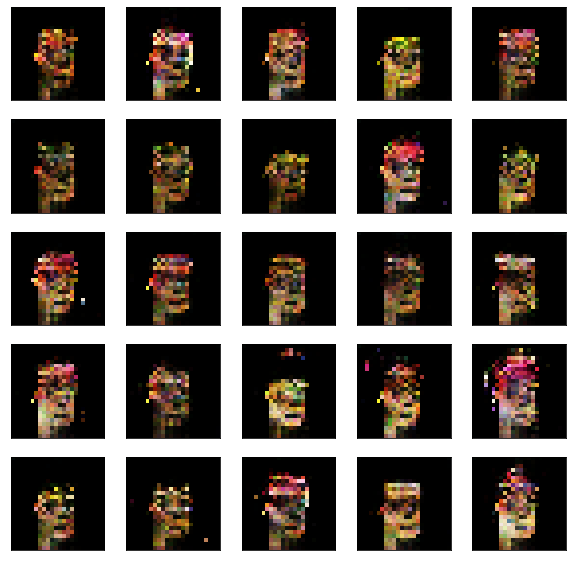

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import PIL

## Read in and organize the data
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)
finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

n = finalArray.shape[0]
x_real = finalArray / 255
x_real = torch.tensor(x_real.astype(np.float32))

## Define our constants for our networks
kernel_size = 5
generator_input_dim = [16, 3, 3]

class create_generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(16, 128, 10, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)
 
## Use the discriminator from the convnet chapter
class create_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 3 * 3, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
        
generator = create_generator()
discriminator = create_discriminator()


# Our label convention, real_label = 1, fake_label = 0

lr = 1e-4

## y is n real images then n fake images
y = torch.concat( (torch.ones(n), torch.zeros(n) ) ) 

## Set up optimizers
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = optim.Adam(generator.parameters(), lr=lr)

## Set up the loss function
loss_function = nn.BCELoss()

## Change to True / False if you do / do noload_state_dictnt to load the previously saved state dictionaries
load = True
if load:
    generator.load_state_dict(torch.load("generator.pt"))
    discriminator.load_state_dict(torch.load("discriminator.pt"))



test_embedding = torch.randn([100]+generator_input_dim)
x_fake = generator(test_embedding)

plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(x_fake.detach().numpy()[i,:,:,:], (1, 2, 0))
  plt.imshow(img)  
